In [53]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
from itertools import product
import warnings
warnings.filterwarnings('ignore')

%reload_ext autoreload
%autoreload 2


#!pip install pmdarima
import pmdarima as pm
from pmdarima.model_selection import train_test_split



from pmdarima.pipeline import Pipeline
from pmdarima.preprocessing import BoxCoxEndogTransformer
import pickle

In [7]:
import sys; sys.path.insert(0, '..')

from src import preprocess as dp
from src import models

In [8]:
#read data
info = pd.read_csv("g-research-crypto-forecasting/asset_details.csv")
ctrain = pd.read_csv("g-research-crypto-forecasting/train.csv")

In [9]:
#choose Bitcoin
btc = dp.c_time_sub(asset_id =1, data = ctrain)

<AxesSubplot:xlabel='timestamp'>

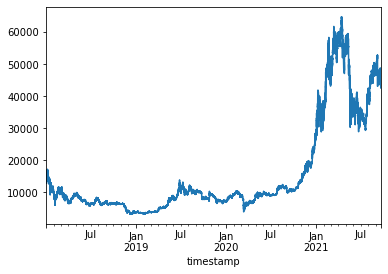

In [10]:
#visualize
btc.Close.plot()

First of all we apply Box-Cox transformation for hourly, daily and monthly rolled btc data since Box-Cox transformation with a particular value of lambda the process may look stationary. It is sometimes possible that even if after applying the Box-Cox transformation the series does not appear to be stationary

In [22]:
#Box-Cox Transformation for minute data
#btc["close_box"], lmbda_2=stats.boxcox(btc.Close)
#print("Dickey–Fuller test: p=%f" % adfuller(btc.close_box)[1])

In [66]:
#Box-Cox Transformation for hourly rolled

btc_hour=btc.resample("H").mean()
btc_hour["close_box"], lmbda=stats.boxcox(btc_hour.Close)

print("Dickey–Fuller test: p=%f" % adfuller(btc_hour.close_box)[1])

Dickey–Fuller test: p=0.853938


In [65]:
#Box-Cox Transformation for daily rolled

btc_day=btc.resample("D").mean()
btc_day["close_box"], lmbda=stats.boxcox(btc_day.Close)

print("Dickey–Fuller test: p=%f" % adfuller(btc_day.close_box)[1])

Dickey–Fuller test: p=0.837497


In [19]:
#Box-Cox Transformation for monthly rolled
btc_month=btc.resample("M").mean()
btc_month["close_box"], lmbda=stats.boxcox(btc_month.Close)
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.close_box)[1])

Dickey–Fuller test: p=0.865378


For hourly,daily and monthly rolled data box coxed transformation is not stationary

Then we check whether differencing will make our data stationary.
We will start to work with monthly rolled data.

In [23]:
# Seasonal differentiation (12 months) of box coxed transformed data
btc_month['box_diff_seasonal_12'] = btc_month.close_box - btc_month.close_box.shift(12)
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.box_diff_seasonal_12[12:])[1])

Dickey–Fuller test: p=0.064401


Looks much more better than without differencing

In [24]:
# Seasonal differentiation (3 months) of box coxed transformed data
btc_month['box_diff_seasonal_3'] = btc_month.close_box - btc_month.close_box.shift(3)
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.box_diff_seasonal_3[3:])[1])

Dickey–Fuller test: p=0.008042


Seasonal differentiation (3 months) of box coxed transformed data made data stationary

Afterwards, we examine Autocorrelation and Partial Autocorrelation Plots
fot monthly rolled data (not box coxed transformed)

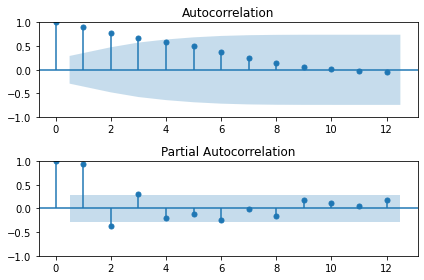

In [25]:
ax = plt.subplot(211)
# Plot the autocorrelation function
plot_acf(btc_month.Close.values.squeeze(), lags=12, ax=ax)
ax = plt.subplot(212)
plot_pacf(btc_month.Close.values.squeeze(), lags=12, ax=ax)
plt.tight_layout()
plt.show()

We see that there are 4 spikes in the ACF, followed by an almost significant spike at lag 5.
In the PACF, there are 4 significant spikes, and then no significant spikes thereafter (apart from one just outside the bounds). We can ignore significant spikes in each plot if it is just outside the limits, and not in the first few lags



Then, we examine Autocorrelation and Partial Autocorrelation Plots
fot monthly rolled data (for box coxed transformed)

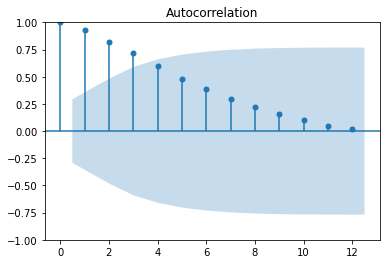

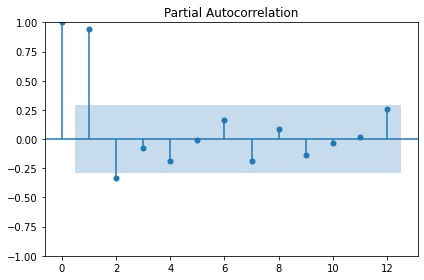

In [26]:
#for box cox transformed close values
plot_acf(btc_month.close_box.values.squeeze(), lags=12)
plot_pacf(btc_month.close_box.values.squeeze(), lags=12)

plt.tight_layout()
plt.show()

# ARIMA for Close feature

In [27]:
PCT_VALIDATION = 0.1 # last 10% of the data are used as validation set

btc_month_train = btc_month[:int(len(btc_month)*(1-PCT_VALIDATION))]
btc_month_train.shape[0]/btc_month.shape[0]

0.8888888888888888

In [28]:
# Initial approximation of parameters manually

qs = range(0, 5)
ps = range(0, 5)
d=1
parameters = product(ps, qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model = SARIMAX(btc_month_train.Close, order=(param[0], d, param[1])).fit(disp=-1)
    except ValueError:
        print('bad parameter combination:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [29]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

   parameters         aic
5      (1, 0)  733.330567
10     (2, 0)  734.679795
12     (2, 2)  734.687896
6      (1, 1)  734.909535
11     (2, 1)  735.871864


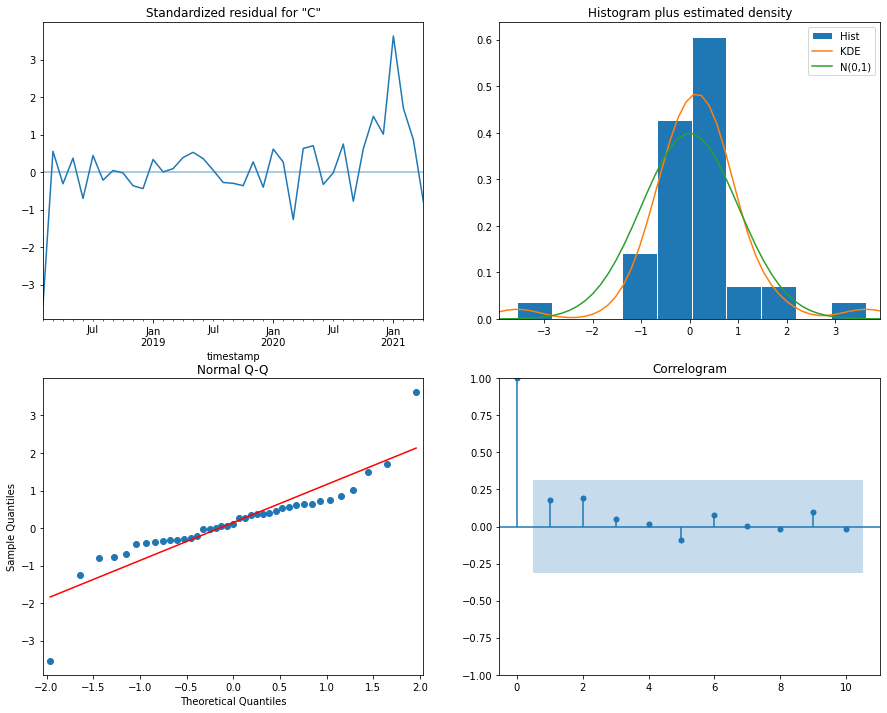

In [30]:
best_model.plot_diagnostics(figsize=(15, 12))
plt.show()

In [31]:
print("Dickey–Fuller test:: p=%f" % adfuller(best_model.resid[13:])[1])

Dickey–Fuller test:: p=0.015737


In [ ]:
forecasts = best_model.predict(start = '2018-01-31',end = '2021-09-30') # predict N steps into the future

forecasts.plot(color='blue', label='Training Data',marker='o')
btc_month.Close.plot(color='red', label='Actual')

Auto tuning of params.
We will use pmdarima library to fit automatically.



Auto_arima is similar to an ARIMA-specific grid search, but (by default) uses a more intelligent stepwise algorithm laid out in a paper by Hyndman and Khandakar (2008). If stepwise is False, the models will be fit similar to a gridsearch. Note that it is possible for auto_arima not to find a model that will converge; if this is the case, it will raise a ValueError.



In [33]:
# fitting a stepwise model for close feat:

stepwise_fit = pm.auto_arima(btc_month.Close, start_p=1, start_q=1, max_p=3, max_q=3, m=12,
                             start_P=0, seasonal=True, d=1, D=1, trace=True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=632.949, Time=0.12 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=640.998, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=634.020, Time=0.04 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=632.735, Time=0.05 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=632.591, Time=0.02 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=633.947, Time=0.04 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=634.398, Time=0.08 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=633.260, Time=0.03 sec
 ARIMA(0,1,2)(0,1,0)[12]             : AIC=631.212, Time=0.02 sec
 ARIMA(0,1,2)(1,1,0)[12]             : AIC=632.271, Time=0.05 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=631.070, Time=0.05 sec
 ARIMA(0,1,2)(1,1,1)[12]             : AIC=632.856, Time=0.09 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=632.513, Time=0.14 sec
 ARIMA(0,1,2)(1,1,2)[12]             : AIC=633.908, Time=0.20 sec
 ARIMA(1,1,2)(0,1,1)[12]         

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                   45
Model:             SARIMAX(0, 1, 2)x(0, 1, [1], 12)   Log Likelihood                -311.535
Date:                              Wed, 12 Jan 2022   AIC                            631.070
Time:                                      12:40:10   BIC                            636.933
Sample:                                           0   HQIC                           633.013
                                               - 45                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.7108      0.178      3.997      0.000       0.362       1.059
ma.L2          0.3478      0.211      1.652      0.099      -0.065       0.760
ma.S.L12      -0.4293      0.251     -1.709      0.087      -0.922       0.063
sigma2      1.768e+07   1.07e-08   1.65e+15      0.000    1.77e+07    1.77e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.28   Jarque-Bera (JB):                 3.69
Prob(Q):                              0.60   Prob(JB):                         0.16
Heteroskedasticity (H):               4.65   Skew:                            -0.55
Prob(H) (two-sided):                  0.02   Kurtosis:                         4.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

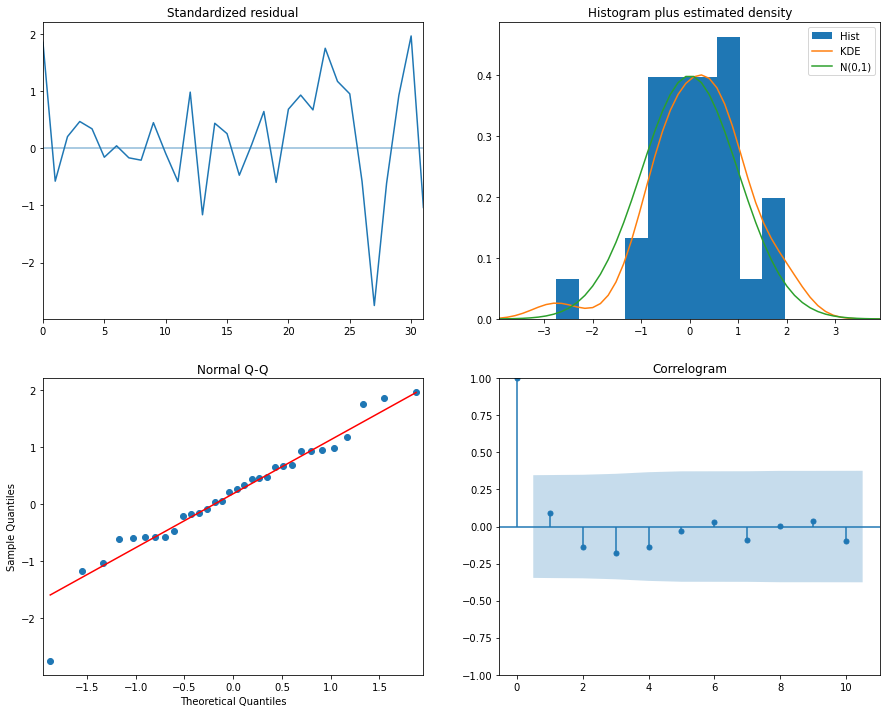

In [34]:
stepwise_fit.plot_diagnostics(figsize=(15, 12))
plt.show()

In [35]:
#stepwise is False for close values
rs_fit = pm.auto_arima(btc_month.Close, start_p=1, start_q=1, max_p=3, max_q=3, m=12,
                       start_P=0, seasonal=True, d=1, D=1, trace=True,
                       n_jobs=-1,  # We can run this in parallel by controlling this option
                       error_action='ignore',  # don't want to know if an order does not work
                       suppress_warnings=True,  # don't want convergence warnings
                       stepwise=False, random=True, random_state=42,  # we can fit a random search (not exhaustive)
                       n_fits=25)

rs_fit.summary()


Best model:  ARIMA(0,1,2)(0,1,0)[12]          
Total fit time: 6.766 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   45
Model:             SARIMAX(0, 1, 2)x(0, 1, [], 12)   Log Likelihood                -312.606
Date:                             Wed, 12 Jan 2022   AIC                            631.212
Time:                                     12:40:57   BIC                            635.609
Sample:                                          0   HQIC                           632.669
                                              - 45                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.6622      0.133      4.997      0.000       0.402       0.922
ma.L2          0.3367      0.176      1.915      0.055      -0.008       0.681
sigma2      1.768e+07   3.53e+06      5.013      0.000    1.08e+07    2.46e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.58   Jarque-Bera (JB):                 5.92
Prob(Q):                              0.45   Prob(JB):                         0.05
Heteroskedasticity (H):               2.78   Skew:                            -0.35
Prob(H) (two-sided):                  0.10   Kurtosis:                         4.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

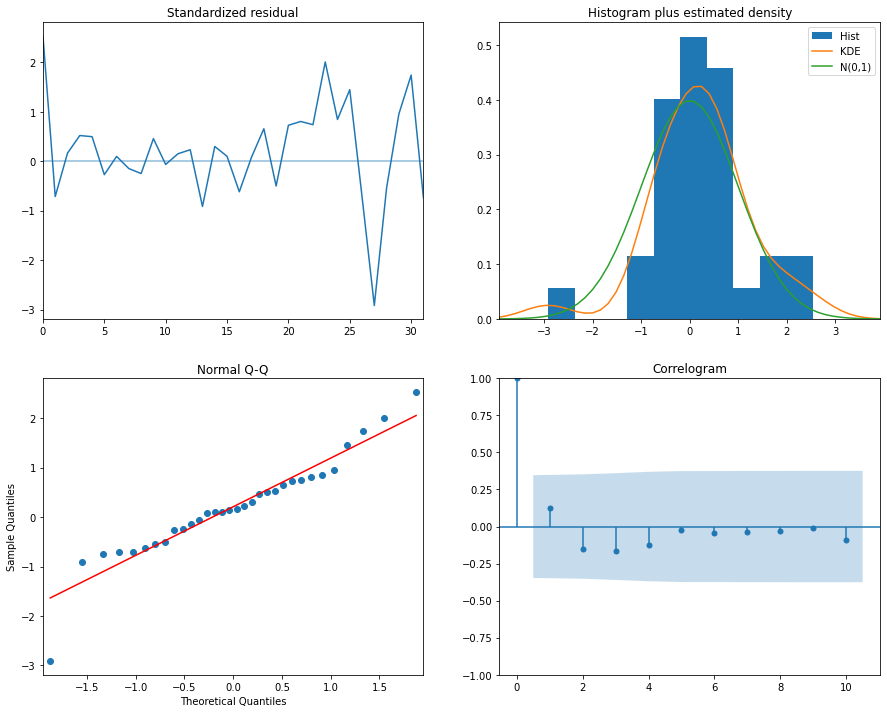

In [36]:
rs_fit.plot_diagnostics(figsize=(15, 12))
plt.show()

Split data into training and test and look at the pedicted results

In [38]:
btc_month.Close.shape

(45,)

In [39]:
train, test = train_test_split(btc_month.Close, train_size=35)

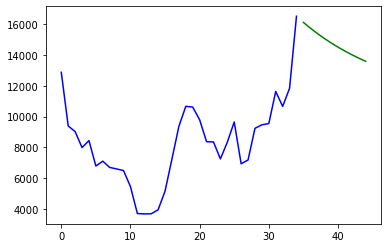

In [40]:
# Fit the model
model = pm.auto_arima(train, seasonal=True, m=12)

# make the forecasts
forecasts,conf_int = model.predict(test.shape[0],return_conf_int=True)  # predict N steps into the future

# Visualize the forecasts (blue=train, green=forecasts)
x = np.arange(btc_month.Close.shape[0])
plt.plot(x[:35], train, c='blue')
plt.plot(x[35:], forecasts, c='green')
plt.show()#%%

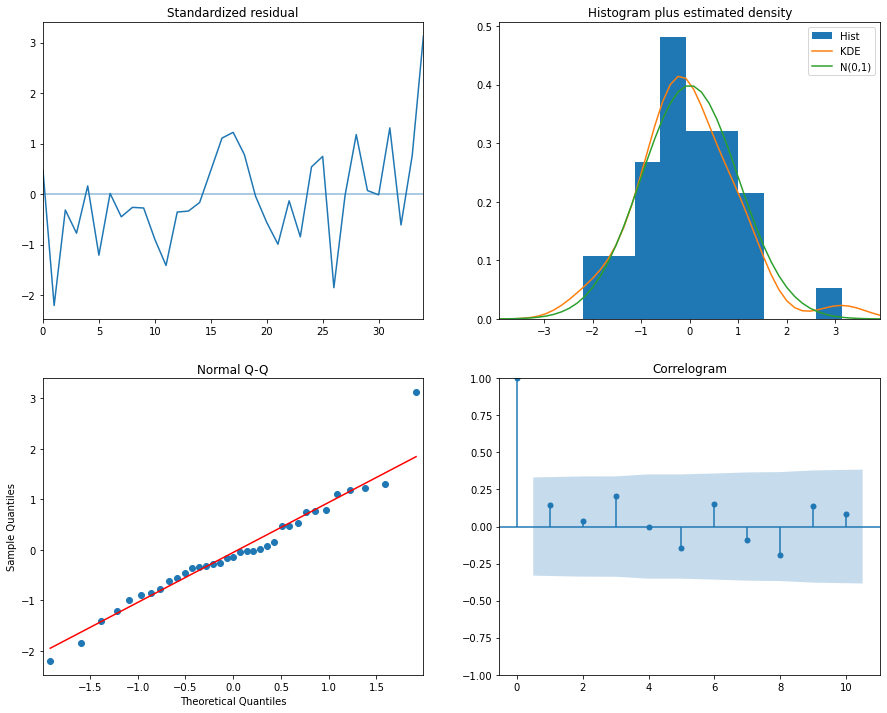

In [41]:
model.plot_diagnostics(figsize=(15, 12))
plt.show()

In [43]:
def plt_arima_result(y_train = train, forecasts = forecasts,y_test = test,conf_int = conf_int ):
    """
    Plot predicted and real
    """
    fig = plt.figure(figsize=(16, 8))
    ax = fig.add_subplot(1, 1, 1)

    n_train = y_train.shape[0]
    x = np.arange(n_train + forecasts.shape[0])

    ax.plot(x[:n_train], y_train, color='blue', label='Training Data')
    ax.plot(x[n_train:], forecasts, color='green', marker='o',
            label='Predicted')
    ax.plot(x[n_train:], y_test, color='red', label='Actual')
    ax.legend(loc='lower left', borderaxespad=0.5)
    ax.set_title('Predicted Foo')
    ax.set_ylabel('# Foo')
    plt.fill_between(x[n_train:],
                 conf_int[:, 0], conf_int[:, 1],
                 alpha=0.1, color='b')

    plt.show()

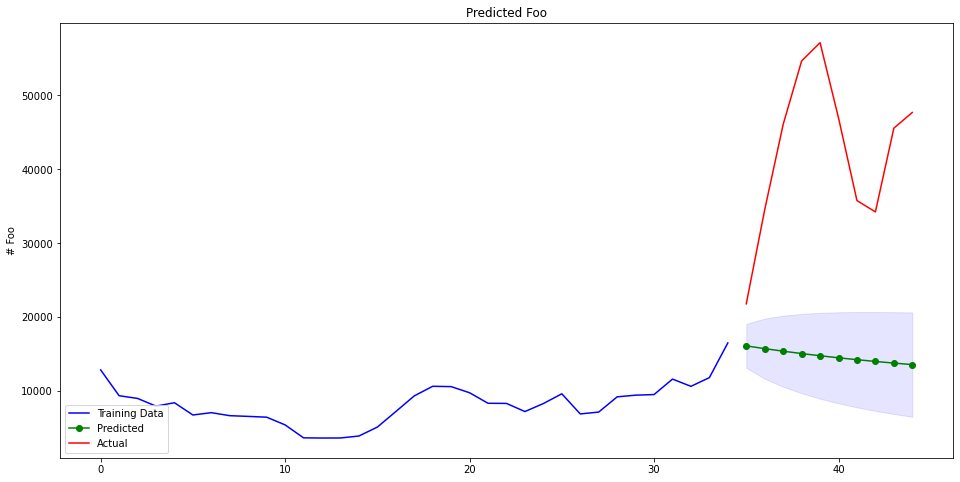

In [44]:
plt_arima_result(y_train = train, forecasts = forecasts,y_test = test )

We can see that arima for monthly data (35 train, 10 tets could not predict properly)

## Predict with BoxCoxEndogTransformer


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.65 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=389.466, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=349.919, Time=0.06 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=367.411, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=503.424, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=347.925, Time=0.02 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=349.912, Time=0.06 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=347.689, Time=0.05 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=349.572, Time=0.10 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : AIC=349.281, Time=0.09 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(3,0,0)(0,0,0)[12] intercept   : AIC=349.609, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=348.997, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=34

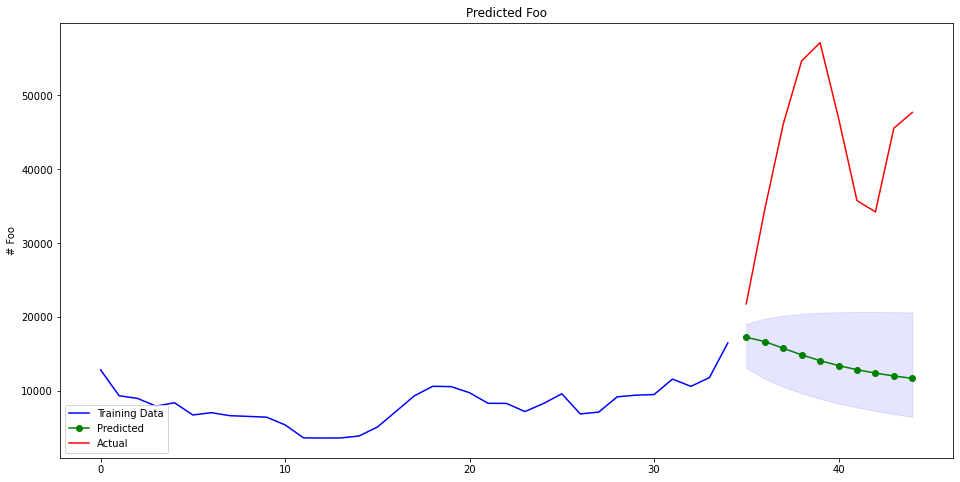

In [58]:
#https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.pipeline.Pipeline.html
#https://github.com/alkaline-ml/pmdarima

# Load/split data
y = btc_month.Close
train_size=35 #35 is used for training
train, test = train_test_split(btc_month.Close, train_size=train_size)

# Define and fit your pipeline
pipeline = Pipeline([
    ('boxcox', BoxCoxEndogTransformer(lmbda2=1e-6)),  # lmbda2 avoids negative values
    ('arima', pm.AutoARIMA(seasonal=True, m=12, #monthly data
                           suppress_warnings=True,
                           trace=True))
])

pipeline.fit(train)

# Serialize the model just like we would in scikit:
with open('model.pkl', 'wb') as pkl:
    pickle.dump(pipeline, pkl)

# Load it and make predictions seamlessly:
with open('model.pkl', 'rb') as pkl:
    mod = pickle.load(pkl)


plt_arima_result(y_train = train, forecasts = mod.predict(10),y_test = test )

Daily prediction with m=7

In [87]:
# Load/split your data
y = btc_day.Close
train_size=int(len(y)*0.8)
train, test = train_test_split(y, train_size=train_size)

# Define and fit your pipeline
pipeline = Pipeline([
    ('boxcox', BoxCoxEndogTransformer(lmbda2=1e-6)),  # lmbda2 avoids negative values
    ('arima', pm.AutoARIMA(seasonal=True, m=7, #hourly data
                           suppress_warnings=True,
                           trace=True))
])

pipeline.fit(train)

# Serialize your model just like you would in scikit:
with open('model_D.pkl', 'wb') as pkl:
    pickle.dump(pipeline, pkl)

# Load it and make predictions seamlessly:
with open('model_D.pkl', 'rb') as pkl:
    mod = pickle.load(pkl)
forecasts ,conf_int = mod.predict(len(y)-train_size,return_conf_int=True)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,0,1)[7]             : AIC=inf, Time=2.30 sec
 ARIMA(0,2,0)(0,0,0)[7]             : AIC=-31.824, Time=0.03 sec
 ARIMA(1,2,0)(1,0,0)[7]             : AIC=-159.767, Time=0.15 sec
 ARIMA(0,2,1)(0,0,1)[7]             : AIC=inf, Time=0.29 sec
 ARIMA(1,2,0)(0,0,0)[7]             : AIC=-159.453, Time=0.04 sec
 ARIMA(1,2,0)(2,0,0)[7]             : AIC=-157.981, Time=0.28 sec
 ARIMA(1,2,0)(1,0,1)[7]             : AIC=-157.862, Time=0.18 sec
 ARIMA(1,2,0)(0,0,1)[7]             : AIC=-159.693, Time=0.14 sec
 ARIMA(1,2,0)(2,0,1)[7]             : AIC=-156.424, Time=0.65 sec
 ARIMA(0,2,0)(1,0,0)[7]             : AIC=-35.427, Time=0.08 sec
 ARIMA(2,2,0)(1,0,0)[7]             : AIC=-287.793, Time=0.12 sec
 ARIMA(2,2,0)(0,0,0)[7]             : AIC=-287.185, Time=0.06 sec
 ARIMA(2,2,0)(2,0,0)[7]             : AIC=-287.064, Time=0.29 sec
 ARIMA(2,2,0)(1,0,1)[7]             : AIC=inf, Time=1.08 sec
 ARIMA(2,2,0)(0,0,1)[7]             : AIC=-287.615

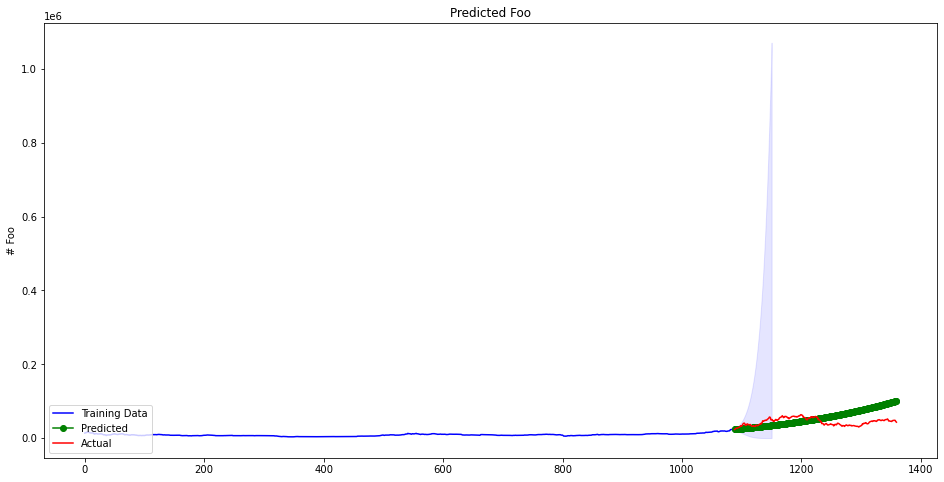

In [88]:
plt_arima_result(y_train = train, forecasts = forecasts,y_test = test,conf_int = conf_int )

In [90]:
conf_int.shape,test.shape

((272, 2), (272,))

Daily prediction with m=14

In [91]:
# Load/split your data
y = btc_day.Close
train_size=int(len(y)*0.8)
train, test = train_test_split(y, train_size=train_size)

# Define and fit your pipeline
pipeline = Pipeline([
    ('boxcox', BoxCoxEndogTransformer(lmbda2=1e-6)),  # lmbda2 avoids negative values
    ('arima', pm.AutoARIMA(seasonal=True, m=14, #hourly data
                           suppress_warnings=True,
                           trace=True))
])

pipeline.fit(train)

# Serialize your model just like you would in scikit:
with open('model_D_14.pkl', 'wb') as pkl:
    pickle.dump(pipeline, pkl)

# Load it and make predictions seamlessly:
with open('model_D_14.pkl', 'rb') as pkl:
    mod = pickle.load(pkl)
forecasts ,conf_int = mod.predict(len(y)-train_size,return_conf_int=True)




Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,0,1)[14]             : AIC=inf, Time=3.76 sec
 ARIMA(0,2,0)(0,0,0)[14]             : AIC=-31.824, Time=0.03 sec
 ARIMA(1,2,0)(1,0,0)[14]             : AIC=-157.732, Time=0.11 sec
 ARIMA(0,2,1)(0,0,1)[14]             : AIC=inf, Time=0.42 sec
 ARIMA(1,2,0)(0,0,0)[14]             : AIC=-159.453, Time=0.04 sec
 ARIMA(1,2,0)(0,0,1)[14]             : AIC=-157.721, Time=0.15 sec
 ARIMA(1,2,0)(1,0,1)[14]             : AIC=inf, Time=1.75 sec
 ARIMA(2,2,0)(0,0,0)[14]             : AIC=-287.185, Time=0.06 sec
 ARIMA(2,2,0)(1,0,0)[14]             : AIC=-286.624, Time=0.19 sec
 ARIMA(2,2,0)(0,0,1)[14]             : AIC=-286.569, Time=0.27 sec
 ARIMA(2,2,0)(1,0,1)[14]             : AIC=-287.274, Time=0.88 sec
 ARIMA(2,2,0)(2,0,1)[14]             : AIC=-285.287, Time=2.11 sec
 ARIMA(2,2,0)(1,0,2)[14]             : AIC=-285.287, Time=2.30 sec
 ARIMA(2,2,0)(0,0,2)[14]             : AIC=-285.006, Time=0.73 sec
 ARIMA(2,2,0)(2,0,0)[14]           

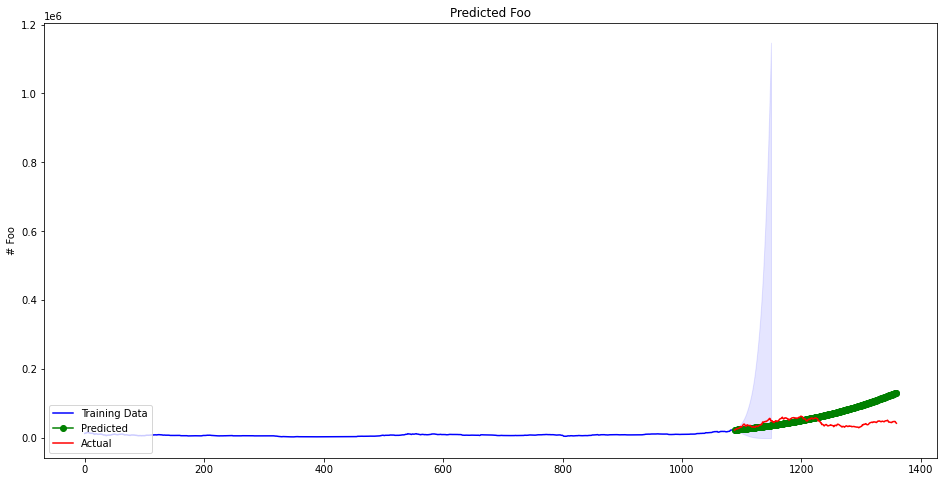

In [92]:
plt_arima_result(y_train = train, forecasts = forecasts,y_test = test,conf_int = conf_int )

Hourly data

In [ ]:
btc_hour=btc.resample("H").mean()


# Load/split your data
y = btc_hour.Close
train_size=int(len(y)*0.8)
train, test = train_test_split(btc_hour.Close, train_size=train_size)

# Define and fit your pipeline
pipeline = Pipeline([
    ('boxcox', BoxCoxEndogTransformer(lmbda2=1e-6)),  # lmbda2 avoids negative values
    ('arima', pm.AutoARIMA(seasonal=True, m=24, #hourly data
                           suppress_warnings=True,
                           trace=True))
])

pipeline.fit(train)

# Serialize your model just like you would in scikit:
with open('model_H.pkl', 'wb') as pkl:
    pickle.dump(pipeline, pkl)

# Load it and make predictions seamlessly:
with open('model_H.pkl', 'rb') as pkl:
    mod = pickle.load(pkl)
forecasts,conf_int = mod.predict(len(y)-train_size)


plt_arima_result(y_train = train, forecasts = forecasts,y_test = test,conf_int= conf_int)









Minute prediction using just 2021

In [100]:
btc_mini = btc[btc.index.year == 2021].copy()

In [101]:
#the last data
btc[-1:]

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,close_box
timestamp,,,,,,,,,,
2021-09-21,1,2698.0,43009.96125,43048.51,42961.64,43002.505,128.20682,43011.414052,NaN,1.932293


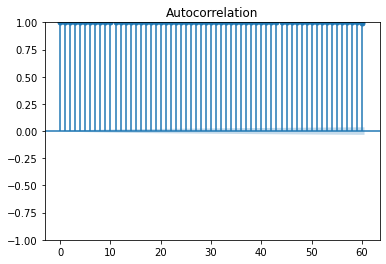

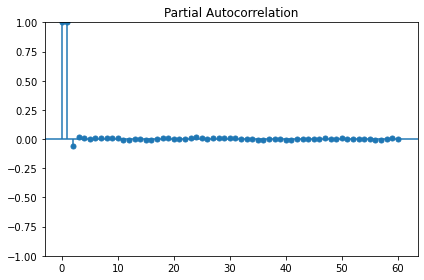

In [102]:
#acf and pacf for Close value
plot_acf(btc_mini.Close.values.squeeze(), lags=60)
plot_pacf(btc_mini.Close.values.squeeze(), lags=60)

plt.tight_layout()
plt.show()


In [ ]:
# Load/split your data
y = btc_mini.Close

train_size=int(len(y)*0.8)
train, test = train_test_split(y, train_size=train_size)

# Define and fit your pipeline
pipeline = Pipeline([
    ('boxcox', BoxCoxEndogTransformer(lmbda2=1e-6)),  # lmbda2 avoids negative values
    ('arima', pm.AutoARIMA(seasonal=True, m =60, #min data
                           suppress_warnings=True,
                           trace=True))
])

pipeline.fit(train)

# Serialize your model just like you would in scikit:
with open('model_M.pkl', 'wb') as pkl:
    pickle.dump(pipeline, pkl)

# Load it and make predictions seamlessly:
with open('model_M.pkl', 'rb') as pkl:
    mod = pickle.load(pkl)
forecasts ,conf_int = mod.predict(len(y)-train_size,return_conf_int=True)


plt_arima_result(y_train = train, forecasts = forecasts,y_test = test,conf_int=conf_int)


Performing stepwise search to minimize aic


In [ ]:
#In ANN models we use 10% for testing - let us try use 10% here as well

# Load/split your data
y = btc_mini.Close

train_size=int(len(y)*0.9)
train, test = train_test_split(y, train_size=train_size)

# Define and fit your pipeline
pipeline = Pipeline([
    ('boxcox', BoxCoxEndogTransformer(lmbda2=1e-6)),  # lmbda2 avoids negative values
    ('arima', pm.AutoARIMA(seasonal=True, m =60, #min data
                           suppress_warnings=True,
                           trace=True))
])

pipeline.fit(train)

# Serialize your model just like you would in scikit:
with open('model_M.pkl', 'wb') as pkl:
    pickle.dump(pipeline, pkl)

# Load it and make predictions seamlessly:
with open('model_M.pkl', 'rb') as pkl:
    mod = pickle.load(pkl)
forecasts ,conf_int = mod.predict(len(y)-train_size,return_conf_int=True)


plt_arima_result(y_train = train, forecasts = forecasts,y_test = test,conf_int=conf_int)

